Aleksei Shokhirev / Portfolio project 4

# Restaurant data cleaning

We have a dataset containing data on various restaurants.
Our goal is to clean that dataset and prepare it for analysis.

In [145]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from fuzzywuzzy import process
import recordlinkage

In [146]:
# import and check dataset
df = pd.read_excel('restaurants_1.xlsx', sheet_name=None)
print(df.keys())

dict_keys(['rest', 'rest_new'])


In [147]:
restaurants = pd.read_excel('restaurants_1.xlsx', sheet_name='rest')
restaurants.head(2)

,Unnamed: 0,Unnamed: 0.1,name,addr,city,phone,cuisine_type,avg_cost_pp
0,0,0,arnie morton's of chicago,435 s. la cienega blv .,los angeles,+(31024)-61501,italian,$50
1,1,1,art's delicatessen,12224 ventura blvd.,studio city,+8187621221,America,$50


In [148]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    340 non-null    int64 
 1   Unnamed: 0.1  340 non-null    int64 
 2   name          337 non-null    object
 3   addr          340 non-null    object
 4   city          340 non-null    object
 5   phone         340 non-null    object
 6   cuisine_type  340 non-null    object
 7   avg_cost_pp   333 non-null    object
dtypes: int64(2), object(6)
memory usage: 21.4+ KB


# String similarity

The restaurants data has been collected from many sources and 'cuisine_type' column has a lot of misspelling and typos. It has so many unique categories but should contain nine cuisine types from category list only. We need to remap 'cuisine_type' column using string similarity method. But first, we have to remove spacing and change capitalization.

In [149]:
# convert 'cuisine_type' column to category
restaurants['cuisine_type'].unique()

array(['italian', 'America', 'asian', 'coffeebar', 'mexican', 'Asien',
       'southernn     ', 'sothwestern', 'American', 'american',
       '   Italien', 'Asia', 'Italia', 'Americen   ', 'italien    ',
       'steakhouses', 'americenn', 'mexicen', 'asia', 'southern',
       'Mexica      ', 'Asia     ', 'asiann', '   america', '    asian',
       'cajun', 'Coffeebar    '], dtype=object)

In [150]:
# change capitalization to lowercase
restaurants['cuisine_type'] = restaurants['cuisine_type'].str.lower()
# strip white spaces
restaurants['cuisine_type'] = restaurants['cuisine_type'].str.strip()

In [151]:
# check unique categories in 'cuisine_type'
unique_categories = restaurants['cuisine_type'].unique()
unique_categories

array(['italian', 'america', 'asian', 'coffeebar', 'mexican', 'asien',
       'southernn', 'sothwestern', 'american', 'italien', 'asia',
       'italia', 'americen', 'steakhouses', 'americenn', 'mexicen',
       'southern', 'mexica', 'asiann', 'cajun'], dtype=object)

In [152]:
# find inconsistent categories in 'cuisine_type'
categories = ['american', 'asian', 'italian', 'coffeebar', 'mexican', 'southwestern', 'steakhouses', 'southern', 'cajun']
inconsistent_category = set(restaurants['cuisine_type']).difference(categories)
inconsistent_category

{'america',
 'americen',
 'americenn',
 'asia',
 'asiann',
 'asien',
 'italia',
 'italien',
 'mexica',
 'mexicen',
 'sothwestern',
 'southernn'}

In [153]:
# calculate similarity of cuisine type from the categories list to all values of unique_categories
for x in categories:
    matches = process.extract(x, unique_categories, limit=len(unique_categories))
    print(matches)

[('american', 100), ('america', 93), ('americen', 88), ('americenn', 82), ('mexican', 80), ('mexica', 71), ('cajun', 68), ('mexicen', 67), ('asian', 62), ('asiann', 57), ('italian', 53), ('asia', 50), ('asien', 46), ('italia', 43), ('italien', 40), ('southern', 38), ('southernn', 35), ('sothwestern', 32), ('coffeebar', 24), ('steakhouses', 21)]
[('asian', 100), ('asiann', 91), ('asia', 89), ('asien', 80), ('italian', 67), ('american', 62), ('italia', 55), ('america', 50), ('mexican', 50), ('italien', 50), ('americen', 46), ('americenn', 43), ('cajun', 40), ('sothwestern', 36), ('mexicen', 33), ('southern', 31), ('southernn', 29), ('coffeebar', 26), ('steakhouses', 25), ('mexica', 18)]
[('italian', 100), ('italia', 92), ('italien', 86), ('asia', 68), ('asian', 67), ('asiann', 62), ('mexican', 43), ('american', 40), ('asien', 33), ('cajun', 33), ('mexica', 31), ('america', 29), ('mexicen', 29), ('americen', 27), ('southern', 27), ('sothwestern', 26), ('steakhouses', 26), ('southernn', 25

Cutoff points are following: american 82, asian 80, italian 86, coffeebar 100, mexican 86, southwestern 96, steakhouses 100, southern 94, cajun 100. As we can see, cajun, steakhouses and coffeebar categories are correct. We can group american, italian, mexican, southwestern, southern categories and establish cutoff point = 82 for them. Cutoff point for aisian category = 80. Lets fix those two groups of categories separately.

In [154]:
# create a list of correct cuisine types for the first group with cutoff point = 82
categories_1 = ['american', 'italian', 'mexican', 'southwestern', 'southern']

In [155]:
# replace inconsistent cuisine types from 'cuisine_type' column with correct categories from the categories_1 list
for cuisine in categories_1:
    matches = process.extract(cuisine, restaurants['cuisine_type'], limit=restaurants.shape[0])
    for potential_match in matches:
        if potential_match[1] >= 82:
            restaurants.loc[restaurants['cuisine_type'] == potential_match[0], 'cuisine_type'] = cuisine

In [156]:
# fix aisian category
matches = process.extract('asian', restaurants['cuisine_type'], limit=restaurants.shape[0])
for potential_match in matches:
    if potential_match[1] >= 80:
        restaurants.loc[restaurants['cuisine_type'] == potential_match[0], 'cuisine_type'] = 'asian'

In [157]:
# check unique categories of 'cuisine_type' column
restaurants['cuisine_type'].unique()

array(['italian', 'american', 'asian', 'coffeebar', 'mexican', 'southern',
       'southwestern', 'steakhouses', 'cajun'], dtype=object)

In [158]:
# convert cuisine_type data to category
restaurants['cuisine_type'] = restaurants['cuisine_type'].astype('category')
assert restaurants['cuisine_type'].dtype == 'category'

# Missing values

In [159]:
# print numbers of missing values by column
restaurants.isna().sum()

Unnamed: 0      0
Unnamed: 0.1    0
name            3
addr            0
city            0
phone           0
cuisine_type    0
avg_cost_pp     7
dtype: int64

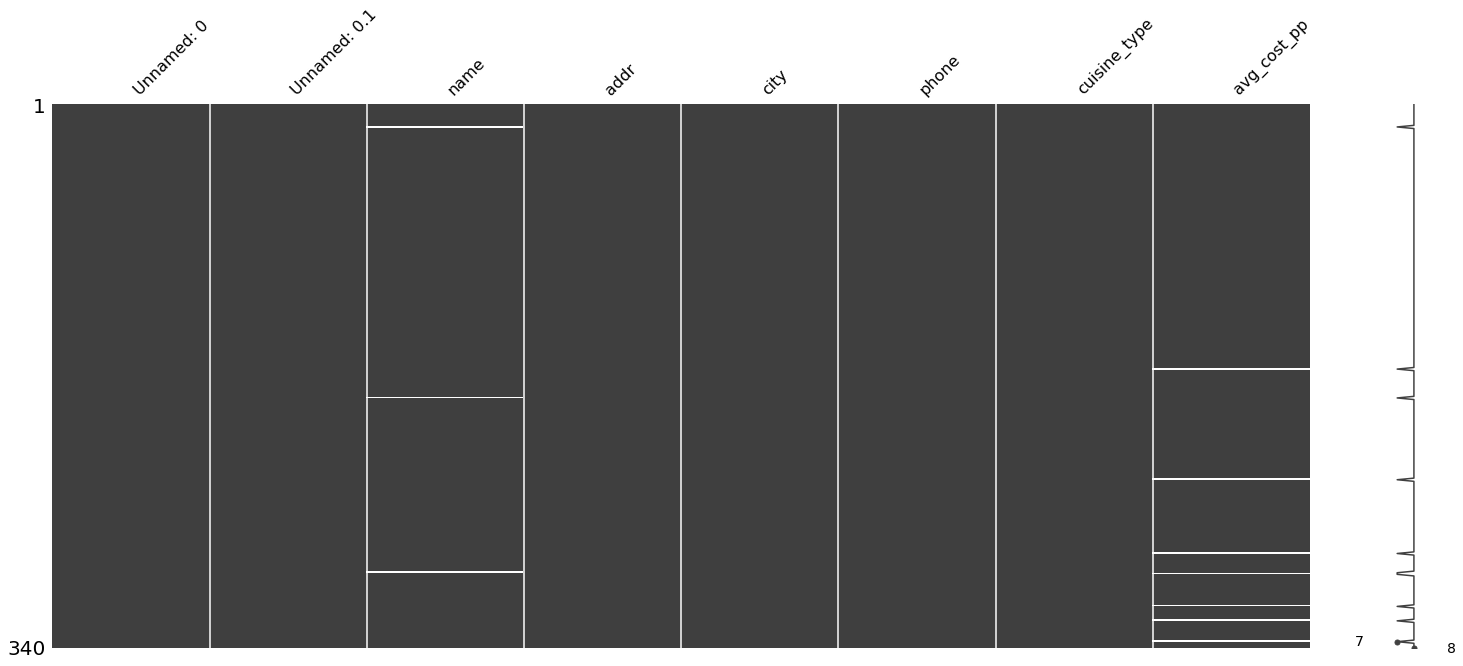

In [160]:
# plot matrix of missing data
msno.matrix(restaurants)
plt.show()

Missing values are randomly distributed over DataFrame columns without any logic. We have no access to the source of data, so we drop missing values of 'name' column and fix missing data of 'avg_cost_pp' column using statistically estimated value. We calculate mean of avg_cost_pp and replace missing data of 'avg_cost_pp' column with calculated value.

In [161]:
# drop missing values of 'name' columns
restaurants.dropna(subset=['name'], inplace=True)
assert restaurants['name'].isna().sum() == 0

In [162]:
restaurants['avg_cost_pp'] = restaurants['avg_cost_pp'].str.replace('$', "")

In [163]:
# isolate missing values
restaurants_missing = restaurants[restaurants['avg_cost_pp'].isna()]
restaurants_complete = restaurants[~restaurants['avg_cost_pp'].isna()]

In [164]:
# convert 'avg_cost_pp' data of restaurants_complete to int
restaurants_complete['avg_cost_pp'] = restaurants_complete['avg_cost_pp'].astype('int')

<ipython-input-164-bcfc031ce93f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurants_complete['avg_cost_pp'] = restaurants_complete['avg_cost_pp'].astype('int')


In [165]:
assert restaurants_complete['avg_cost_pp'].dtype == 'int'

In [166]:
# compute mean of 'avg_cost_pp' column of restaurants_complete
mean = restaurants_complete['avg_cost_pp'].mean()
mean

83.75757575757575

In [167]:
# inpute the missing values of 'avg_cost_pp' in restaurants DF with estimated mean value
restaurants.fillna({'avg_cost_pp':mean}, inplace=True)

In [168]:
# convert 'avg_cost_pp' column in restaurants DF to int
restaurants['avg_cost_pp'] = restaurants['avg_cost_pp'].astype('int')
assert restaurants['avg_cost_pp'].dtype == 'int'

In [169]:
# check 'avg_cost_pp' for missing values
restaurants['avg_cost_pp'].isna().sum()

0

# Uniqueness constrains

Check our restaurants DF for duplicates, drop complete duplicates and fix incomplete ones using grouping and aggregation

In [170]:
# find duplicates accross 'name' and 'addr' columns
duplicates = restaurants.duplicated(subset=['name', 'addr'], keep=False)
restaurants[duplicates]

,Unnamed: 0,Unnamed: 0.1,name,addr,city,phone,cuisine_type,avg_cost_pp
22,22,22,gramercy tavern,42 e. 20th st. between park ave. s and broadway,new york,+2124770777,american,100
23,22,22,gramercy tavern,42 e. 20th st. between park ave. s and broadway,new york,+2124770777,american,100
46,45,45,georgia grille,2290 peachtree rd. . peachtree square shoppin...,atlanta,+4043523517,american,80
47,45,45,georgia grille,2290 peachtree rd. . peachtree square shoppin...,atlanta,+4043523517,american,80
100,98,98,trader vic's,9876 wilshire blvd.,los angeles,+3102766345,american,90
101,98,98,trader vic's,9876 wilshire blvd.,los angeles,+3102766345,american,60
154,151,151,fleur de jour,348 e. 62nd st.,new york,+2123552020,asian,90
155,151,151,fleur de jour,348 e. 62nd st.,new york,+2123552020,asian,110


In [171]:
# drop complete duplicates
restaurants.drop_duplicates(inplace=True)

In [172]:
# drop incomplete duplicates by grouping and aggregation
columns = ['name', 'addr', 'city', 'phone', 'cuisine_type']
restaurants['cuisine_type'] = restaurants['cuisine_type'].astype('string')
restaurants = restaurants.groupby(columns).agg({'avg_cost_pp':'mean'}).reset_index()

In [173]:
# find duplicates again and run assert statement to verify de_duplication
duplication = restaurants.duplicated(subset=['name', 'addr'], keep=False)
assert restaurants[duplication].shape[0] == 0

Finally, fix 'phone' column extracting digits only from that column

In [174]:
restaurants['phone'] = restaurants['phone'].str.replace(r'\D+', "")
restaurants['phone'].head(3)

0    2129640380
1    2125827200
2    4154310692
Name: phone, dtype: object

# Record linkage

We clean restaurants DF precisely. But we have new DataFrame named restaurants_new containing data of new restaurants, which has been scraped from new data source. We need to join two DataFrames. There is no common unique identifier between two DFs and duplicates in restaurant`s names are possible. That is why we use record linkage instead of regular join method. 

In [175]:
# import data
df = pd.read_excel('restaurants_1.xlsx', sheet_name=None)
print(df.keys())

dict_keys(['rest', 'rest_new'])


In [176]:
restaurants_new = pd.read_excel('restaurants_1.xlsx', sheet_name='rest_new')
restaurants_new.head(2)

,Unnamed: 0,Unnamed: 0.1,name,addr,city,phone,type,avg_cost_pp
0,0,0,kokomo,6333 w. third st.,la,2139330773,american,$50
1,1,1,feenix,8358 sunset blvd. west,hollywood,2138486677,american,$50


In [177]:
restaurants_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    82 non-null     int64 
 1   Unnamed: 0.1  82 non-null     int64 
 2   name          82 non-null     object
 3   addr          82 non-null     object
 4   city          82 non-null     object
 5   phone         82 non-null     int64 
 6   type          82 non-null     object
 7   avg_cost_pp   82 non-null     object
dtypes: int64(3), object(5)
memory usage: 5.2+ KB


In [178]:
restaurants_new.head(2)

,Unnamed: 0,Unnamed: 0.1,name,addr,city,phone,type,avg_cost_pp
0,0,0,kokomo,6333 w. third st.,la,2139330773,american,$50
1,1,1,feenix,8358 sunset blvd. west,hollywood,2138486677,american,$50


In [179]:
# convert data of 'avg_cost_pp' into int
restaurants_new['avg_cost_pp'] = restaurants_new['avg_cost_pp'].str.strip('$')
restaurants_new['avg_cost_pp'] = restaurants_new['avg_cost_pp'].astype('int')
assert restaurants_new['avg_cost_pp'].dtype == 'int'

In [180]:
# replace 'la' to 'los angeles' in 'city' column
restaurants_new['city'] = restaurants_new['city'].replace({'la':'los angeles'})
assert restaurants_new.loc[restaurants_new['city'] == 'la', 'city'].shape[0] == 0

In [181]:
restaurants_new['cuisine_type'] = restaurants_new['type']
del restaurants_new['type']

In [182]:
restaurants_new = restaurants_new[['name', 'addr', 'city', 'phone', 'cuisine_type', 'avg_cost_pp']]

In [183]:
# create indexing object
indexer = recordlinkage.Index()

In [184]:
# block pairing on 'cuisine_type' column
indexer.block('cuisine_type')

<Index>

In [185]:
# generate pairs
pairs = indexer.index(restaurants, restaurants_new)
# resulting object is pandas multi index object containing pairs of row indices from both DF
print(pairs)

MultiIndex([(  0, 24),
            (  0, 63),
            (  0, 66),
            ( 16, 24),
            ( 16, 63),
            ( 16, 66),
            ( 22, 24),
            ( 22, 63),
            ( 22, 66),
            ( 33, 24),
            ...
            (227, 55),
            (238, 55),
            (239, 55),
            (241, 55),
            (243, 55),
            (261, 55),
            (270, 55),
            (302, 55),
            (313, 55),
            (329, 55)],
           length=2439)


In [186]:
# create comparison object
comp_cl = recordlinkage.Compare()
# find exact matches
comp_cl.exact('city', 'city', label='city')
comp_cl.exact('cuisine_type', 'cuisine_type', label='cuisine_type')

<Compare>

In [187]:
# find similar strings
comp_cl.string('name', 'name', threshold=0.80, label='res_name')

<Compare>

In [188]:
# compute potential matches
potential_matches = comp_cl.compute(pairs, restaurants, restaurants_new)
potential_matches

city  cuisine_type  res_name
0   24     0             1       0.0
    63     0             1       0.0
    66     0             1       0.0
16  24     0             1       0.0
    63     0             1       0.0
...      ...           ...       ...
261 55     1             1       0.0
270 55     0             1       0.0
302 55     0             1       0.0
313 55     0             1       0.0
329 55     0             1       0.0

[2439 rows x 3 columns]

In [189]:
# isolate potential matches with row sum >= 3
matches = potential_matches[potential_matches.sum(axis=1) >= 3]
matches

,,city,cuisine_type,res_name
18,28,1,1,1.0
60,74,1,1,1.0
124,27,1,1,1.0
236,50,1,1,1.0


In [190]:
# extract indices of restaurants_new from matches
matching_indices = matches.index.get_level_values(1)
matching_indices

Int64Index([28, 74, 27, 50], dtype='int64')

In [191]:
# subset restaurants_new for rows, that are not in matching_indices
non_dup = restaurants_new[~restaurants_new.index.isin(matching_indices)]

In [192]:
# link DFs
restaurants_full = restaurants.append(non_dup)
restaurants_full.head(2)

,name,addr,city,phone,cuisine_type,avg_cost_pp
0,20 mott,20 mott st. between bowery and pell st.,new york,2129640380,mexican,90
1,21 club,21 w. 52nd st.,new york,2125827200,asian,30


# Remapping categories

As a final step, we need to collapse data of 'avg_cost_pp' into 3 categories: '<50', '50-100' and '100+' and create new column 'cost_range'

In [193]:
range = [0, 50, 100, np.inf]
group_names = ['<50', '50-100', '100+']
restaurants_full['cost_range'] = pd.cut(restaurants_full['avg_cost_pp'], bins=range, labels=group_names)
restaurants_full.head(2)

,name,addr,city,phone,cuisine_type,avg_cost_pp,cost_range
0,20 mott,20 mott st. between bowery and pell st.,new york,2129640380,mexican,90,50-100
1,21 club,21 w. 52nd st.,new york,2125827200,asian,30,<50


Dataset restaurants_full is clean and prepared for analysis!